# Tarea 9
Puede ver el código original en el siguiente link: https://colab.research.google.com/drive/1CkgCqGte8LnUKWMoOlVlCr9KRNPKDf3-?usp=sharing

# Funciones auxiliares

En la siguiente celda, se podrán encontrar funciones que son útiles al momento de estar trabajando en esta materia, cada función tiene su propia descripción y uso. Ya tengo un documento plantilla para copiar y pegar estas funciones por lo que puede llegar el caso de que no usemos alguna de las funcioens que estén aquí.

In [1]:
# Este script tiene algunas funciones que son útiles tanto en tareas como en apuntes de la clase
# Importando librerías
import cv2 # Para manejar imágenes
import matplotlib.pyplot as plt # Para visualizar las imágenes (Se puede hacer de otra manera con una librería de google pero meh, este está bueno)
import numpy as np # Para operar matrices de manera sencilla
from scipy.ndimage import correlate, convolve


##### Operaciones iniciales con imágenes (Leer, mostrar, mostrar histogramas, etc.) #####
# Desplegar histogramas
# Leer imagen en escala de grises
def read_img(img_name, **kwarg):
	"""Lee imágenes con ayuda de opencv y la muestra

	Args:
		img_name (str): Nombre del path donde se encuentra la imagen

	Returns:
		np.array: Retorna la imagen que se leyó después de mostrarla
	"""
	img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
	show_img(img, is_gray = True, info = True, **kwarg)
	return img

# Mostrar imágenes
def show_img(img, size = (7, 7), is_gray = True, info = False, is_double = False):
    """Muestra una imagen con tamaño específico.

    Args:
        img (np.array): Imagen que se desea mostrar
        size (tuple, optional): Tamaño relativo de la imagen. Recomendado (7, 7).
        is_gray (bool, optional): Si la imagen es en blanco y negro activar. Recomendado True.
        info (bool, optional): Muestra información de la imagen como el alto, ancho, cantidad de pixeles, etc. Recomendado False.
    """
    vmin = 0
    vmax = 1 if is_double else 255

    fig, axs = plt.subplots(figsize=size)
    if is_gray:
        axs.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    else:
        axs.imshow(img)
    axs.axis("off")

    if info:
        print(f"Imagen de dimensiones: {img.shape}, con un total de {img.size} pixeles")

# Mostrar varias imágenes
def show_imgs_row(imgs, size = (7,7), is_gray = True, info = False, titles = None, is_double = False, max_pixels = 255):
    """Muestra imágenes en una sola fila (se recomiendan menos de 5 imágenes para mejor visibilidad)

    Args:
        imgs (List[np.array]): Lista de imágenes a desplegar
        size (tuple, optional): Tamaño relativo de cada imagen a desplegar. Recomendado (7,7).
        is_gray (bool, optional): Si es o no blanco y negro. Recomendado True.
        info (bool, optional): Muestra información de la imagen como el alto, ancho, cantidad de pixeles, etc. Recomendado False.
        titles (_type_, optional): Lista de títulos para la imagen. Recomendado None.
    """
    schema = (1, len(imgs))
    options = {}
    if is_gray:
        options["cmap"] = "gray"
        options["vmin"] = 0

    fig, axs = plt.subplots(*schema, figsize=size)

    for index in range(len(imgs)):
        vmax = 1 if is_double and is_double[index] else max_pixels
        axs[index].imshow(imgs[index], vmax = vmax, **options)
        axs[index].axis("off")
        if titles:
            axs[index].set_title(titles[index])

def show_histograms(imgs, bin_value = 20, colors = [None, "g"], titles = ["Normal", "No normal"], normalized = True, edgecolor = "black", cumulative = False, size = (15, 5), **kwargs):
	"""Muestra y regresa histogramas de las imágenes que le pases.

	Args:
		imgs (List[np.array]): Lista de imágenes a calcular sus histograms
		bin_value (int, optional): Rango de los bins en nuestros plots. Recomendado 20.
		colors (list, optional): Lista de colores para los histogramas. Recomendado [None, "g"].
		titles (list, optional): Lista de títulos para los histogramas. Recomendado ["Normal", "No normal"].
		normalized (bool, optional): Dicta si los histogramas están normalizados o no. Recomendado True.
		edgecolor (str, optional): El color del borde de cada bin, también se puede dejar en None si no quieres borde. Recomendado "black".
		cumulative (bool, optional): Esto indica si los histogramas son acumultivos o no. Recomendado False.
		size (tuple, optional): Tamaño de las gráficas. Recomendado (15, 5).

	Returns:
		hist: Lista con los histogramas calculados.
		bins: Lista con los bins calculados aunque usualmente son iguales todos.
	"""
	if type(imgs) != list:
		imgs = [imgs]
	if type(titles) != list:
		titles = [titles]
	
	flattens = np.array(list(map(lambda img: img.ravel(), imgs)))
	bins = np.array([np.linspace(0, 255, bin_value) for i in range(len(imgs))])
	hists = []
	fig, ax = plt.subplots(1, len(imgs), figsize = size)
	
	if len(imgs) == 1:
		img, b = imgs[0], bins[0]
		
		hist, b = np.histogram(img, bins = b)
		if normalized:
			hist = hist / img.size
		if cumulative:
			hist = np.cumsum(hist)
		ax.hist(b[:-1], b, weights = hist, color = colors[0], edgecolor = edgecolor, **kwargs)
		ax.set_title(titles[0])
		return hist, b
	else:
		for index in range(len(flattens)):
			img, b = imgs[index], bins[index]
			hist, b = np.histogram(img, bins = b)
			if normalized:
				hist = hist / img.size
			if cumulative:
				hist = np.cumsum(hist)
			
			ax[index].hist(b[:-1], b, weights = hist, color = colors[index], edgecolor = edgecolor, **kwargs)
			ax[index].set_title(titles[index])
			hists.append(hist)
	return hists, bins

###### Transformaciones generales sobre imágenes ######
# Creditos: http://learnwebgl.brown37.net/08_projections/projections_mapping.html
def img_scale(img, minf, maxf):
    a, b = np.min(img), np.max(img)
    scale = (maxf - minf)/(b - a)
    offset = -a*scale + minf
    rescaled = img*scale + offset
    return rescaled

###### Transformaciones de intensidades de imágenes ######

# Binarize images

# Transformación Negativa
def imcomplement(img):
	"""Función para generar el negativo de una imagen en blanco y negro

	Args:
		img (np.array): Imagen a negativizar

	Returns:
		negative_img: Imagen negativa
	"""
	return np.abs(255 - img)

# Genera imagenes binarias
def binarize(img, max_val):
	"""Genera imágenes binarias a partir de un cierto max_val

	Args:
		img (np.array): Imagen a binarizar
		max_val (int): Límite en el cual se considera 1 o 0

	Returns:
		binarized_img: Imagen binaria obtenida
	"""
	return (img >= max_val) * 255

# Credits: https://www.nzfaruqui.com/contrast-stretching-in-image-processing-using-matlab/
def imadjust(img,lim_in = [0, 1], lim_out = [0, 1], gamma=1, plot = False):
	"""Imagen que ajusta a un rango determinado con una gamma correction definida (Hace lo mismo que la función de matlab)

	Args:
		img (np.array): Imagen a transformar
		lim_in (list, optional): Limites de la imagen de input. Defaults to [0, 1].
		lim_out (list, optional): Limites de la imagen de output. Defaults to [0, 1].
		gamma (int, optional): Factor gamma de la función. Defaults to 1.
		plot (bool, optional): Si se desea graficar le función gamma. Defaults to False.

	Returns:
		adjusted_img: Imagen ajustada
	"""
	c, d = lim_in
	a, b = lim_out
	# Normalización para que esto funcione
	img_cp = img.copy()
	if np.max(img_cp) > 1:
		img_cp = img_cp / np.max(img_cp)

	# Básicamente esto es lo que hace imadjust ☝ ver la fuente para mayor información
	adj = (((img_cp - a) / (b - a)) ** gamma) * (d - c) + c
	# Regresando a las dimensiones originales
	adj = np.int64(adj / np.max(adj) * 255)

	# Grafica la función
	if plot:
		x = np.linspace(0, 1, 1000)
		y = (((x - a) / (b - a)) ** gamma) * (d - c) + c
		plt.plot(x,y, c='g')
		plt.title(f'Función adjust con a={a}, b={b}, c={c}, d={d}, gamma={gamma}')
	return adj

def equalizeHist(img):
	"""Función que ecualiza el histograma de una imagen

	Args:
		img (np.array): Imagen a ser ecualizada

	Returns:
		equ_img: Imagen Ecualizada
	"""
	return cv2.equalizeHist(img)

###### fspecials ######
def fspecial_gauss(kernel_shape=(3,3), sigma=0.5):
    m,n = [(ss-1.)/2. for ss in kernel_shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def fspecial_laplacian(alpha = 1/5):
    alpha = max(0,min(alpha,1))
    h1 = alpha/(alpha+1)
    h2 = (1-alpha)/(alpha+1)
    h = np.array([[h1, h2, h1], [h2, -4/(alpha + 1), h2], [h1, h2, h1]])
    return h

def fspecial_average(shape):
	h = np.ones(shape)/np.prod(shape)
	return h

##### NORMALIZE IMAGES #############
def normalize_img(img, norm_factor = 1):
	if (np.max(img) - np.min(img)) != 0:
		return (img - np.min(img)) / (np.max(img) - np.min(img)) * norm_factor
	
	return img / np.max(img)

# Problemas y resolución

## 1. (1 puntos) Lea la imagen Fig0409(a).tif, llame al arreglo Im1, conviertalo en una imagen de dobles usando im2double. Calcule su transformada de Fourier y el resultado guardelo en FFTIm1. Calcule la magnitud de FFTIm1 y guárdelo en MagFFTIm1. Calcule la fase de FFTIm1 y guárdela en FaseFFTIm1.

Imagen de dimensiones: (600, 600), con un total de 360000 pixeles


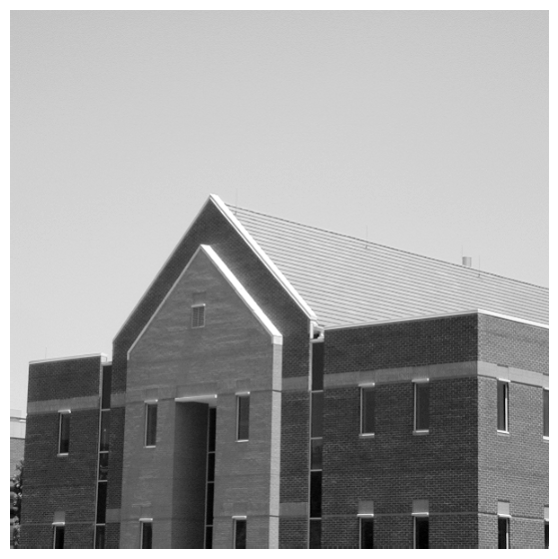

In [2]:
# Leer imágen
img1 = read_img('Fig0409(a).tif')
# Convertir a double
img1 = img1/np.max(img1)

In [3]:
# Calcule su transformada de Fourier y el resultado guardelo en FFTIm1.
from scipy.fft import fft2, fftshift, ifftshift, ifft2

In [4]:
fft_img1 = fftshift(fft2(img1))
# Calcule la magnitud de FFTIm1 y guárdelo en MagFFTIm1
mag_fft_img1 = np.abs(fft_img1)
# Calcule la fase de FFTIm1 y guárdela en FaseFFTIm1
fase_fft_img1 = np.angle(fft_img1)

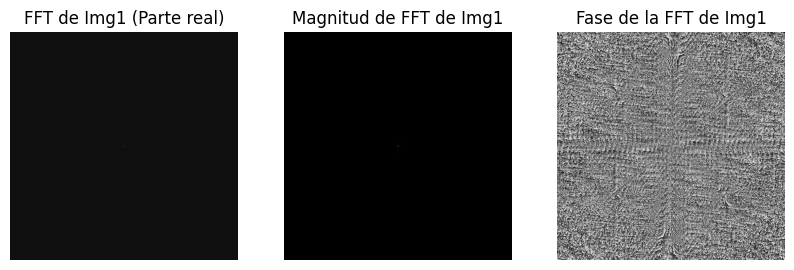

In [5]:
# Normalizamos, si no normalizamos salen cosas extrañas en las imágenes
show_imgs_row(
    [normalize_img(np.real(fft_img1)), normalize_img(mag_fft_img1), normalize_img(fase_fft_img1)],
    titles = [
        "FFT de Img1 (Parte real)",
        "Magnitud de FFT de Img1",
        "Fase de la FFT de Img1"
    ],
    is_double = [True, True, True],
    size = (10,10)
)

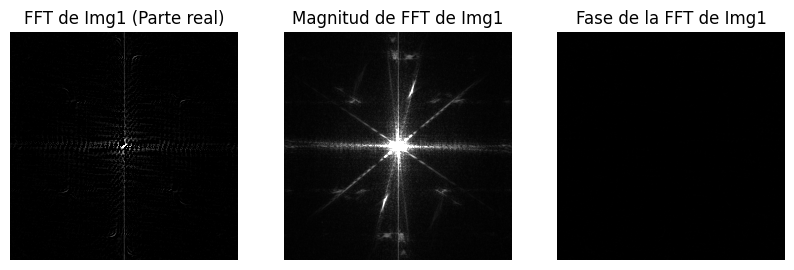

In [6]:
# Vea un ejemplo de las imágenes no normalizadas (Se ven cool, pero pueden ser engañosas)
show_imgs_row(
    [np.real(fft_img1), mag_fft_img1, fase_fft_img1],
    titles = [
        "FFT de Img1 (Parte real)",
        "Magnitud de FFT de Img1",
        "Fase de la FFT de Img1"
    ],
    is_double = [False, False, False],
    size = (10,10)
)

## 2. (1 puntos) Genere una imagen de doubles del tamaño de Im1 que tenga ceros y un rectángulo blanco centrado de 200 renglones y 50 columnas, llame a la imagen Im2. Calcule su transformada de Fourier y el resultado guardelo en FFTIm2. Calcule la magnitud de FFTIm2 y guárdelo en MagFFTIm2. Calcule la fase de FFTIm2 y guárdela en FaseFFTIm2.

In [7]:
# Generando 0's
height, width = img1.shape
img2 = np.zeros((height, width))
# Crea un rectángulo blanco centrado de 200 renglones y 50 columnas

rect_height, rect_width = 200, 50
rect_y1 = (height - rect_height) // 2
rect_y2 = rect_y1 + rect_height
rect_x1 = (width - rect_width) // 2
rect_x2 = rect_x1 + rect_width
img2[rect_y1:rect_y2, rect_x1:rect_x2] = 255

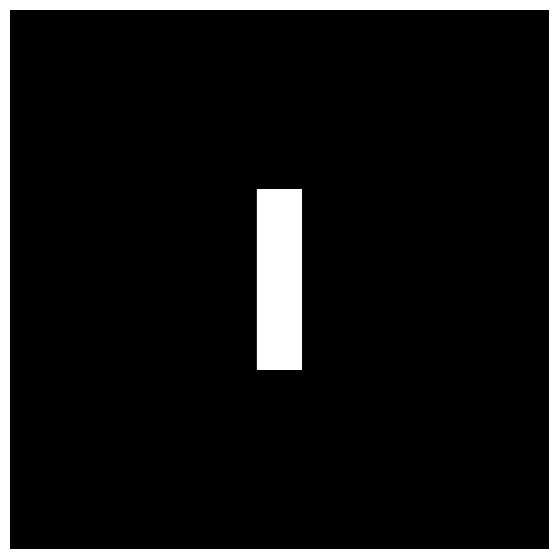

In [8]:
# Mostrando
show_img(img2, is_double = True)

In [9]:
# Calcule la magnitud de FFTIm2 y guárdelo en MagFFTIm2. Calcule la fase de FFTIm2 y guárdela en FaseFFTIm2.
fft_img2 = fftshift(fft2(img2))
# Calcule la magnitud de FFTIm1 y guárdelo en MagFFTIm1
mag_fft_img2 = np.abs(fft_img2)
# Calcule la fase de FFTIm1 y guárdela en FaseFFTIm1
fase_fft_img2 = np.angle(fft_img2)

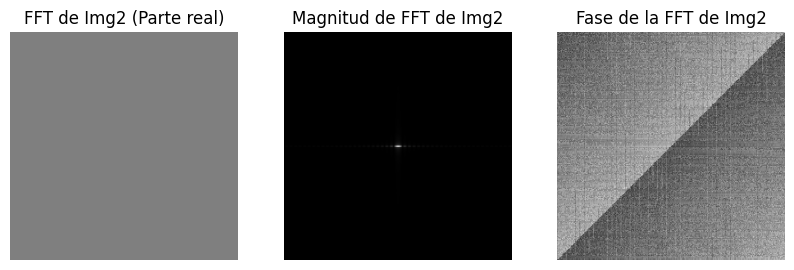

In [10]:
# Mostrando imágenes normalizadas
show_imgs_row(
    [normalize_img(np.real(fft_img2)), normalize_img(mag_fft_img2), normalize_img(fase_fft_img2)],
    titles = [
        "FFT de Img2 (Parte real)",
        "Magnitud de FFT de Img2",
        "Fase de la FFT de Img2"
    ],
    is_double = [True, True, True],
    size = (10,10),
)

## 3. (1 punto) Forme una imagen que se llame MagUnos que tenga el mismo tamaño de Im1 y que contenga puros 1’s, forme una imagen que se llame FasePiMedios que tenga el mismo tamaño de Im1y esté lleno de pi/2 radianes.

In [11]:
# Llena de 1's
mag_unos = np.ones(img1.shape)
# Llena de pi/medios
fase_pi_medios = np.full(img1.shape, np.pi / 2)

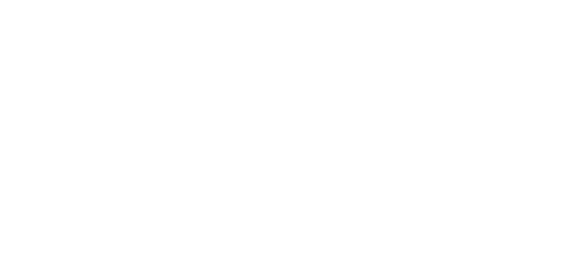

In [12]:
# Mostrar (Aunque no se ve nada por obvias razones)
show_imgs_row(
    [normalize_img(mag_unos), normalize_img(fase_pi_medios)],
    is_double = [True, True],
)

## 4. (1 puntos) Genere una nueva transformada de Fourier que se llame FFTMagIm2FaseIm1 formada con la magnitud MagFFTIm2 y la fase FaseFFTIm1. A la transformada resultante apliquele la transformada inversa (ifft2) y despliegue la imagen obtenida. ¿Qué se ve?

In [22]:
# Combina la magnitud de mag_fft_img2 y la fase de fase_fft_img1 para crear una nueva Transformada de Fourier
fft_mag_img2_fase_img1 = np.abs(ifftshift(mag_fft_img2)) * np.exp(1j * ifftshift(fase_fft_img1))

# Aplica la Transformada de Fourier Inversa (IFFT) a la nueva Transformada de Fourier
inv_fft_mag_img2_fase_img1 = np.real(ifft2(fft_mag_img2_fase_img1))

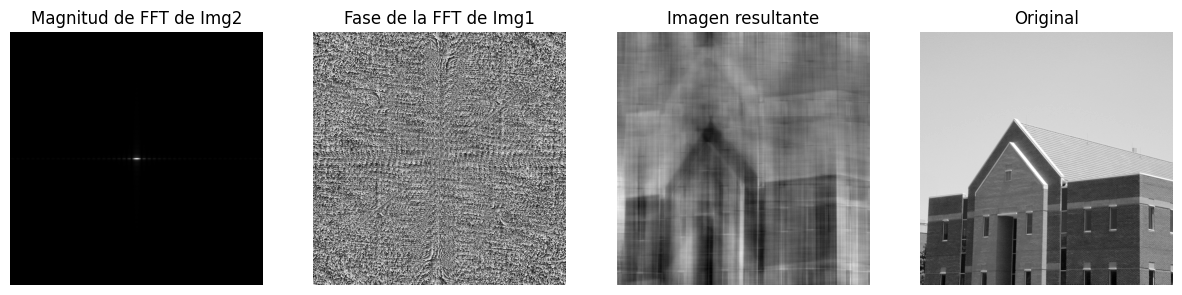

In [36]:
# Mostrando imágenes normalizadas
show_imgs_row(
    [normalize_img(mag_fft_img2), normalize_img(fase_fft_img1), normalize_img(inv_fft_mag_img2_fase_img1), img1],
    titles = [
        "Magnitud de FFT de Img2",
        "Fase de la FFT de Img1",
        "Imagen resultante",
        "Original"
    ],
    is_double = [True, True, True, True],
    size = (15,15),
)

La imagen resultante mostrará una combinación de características de ambas imágenes, es decir, la magnitud de la Transformada de Fourier de img2 y la fase de la Transformada de Fourier de img1.

## 5. (1 puntos) Genere una nueva transformada de Fourier que se llame FFTMagIm1FaseIm2 formada con la magnitud MagFFTIm1 y la fase FaseFFTIm2. A la transformada resultante apliquele la transformada inversa (ifft2) y despliegue la imagen obtenida. ¿Qué se ve?



In [24]:
# Combina la magnitud de mag_fft_img2 y la fase de fase_fft_img1 para crear una nueva Transformada de Fourier
fft_mag_img1_fase_img2 = np.abs(ifftshift(mag_fft_img1)) * np.exp(1j * ifftshift(fase_fft_img2))

# Aplica la Transformada de Fourier Inversa (IFFT) a la nueva Transformada de Fourier
inv_fft_mag_img1_fase_img2 = np.real(ifft2(fft_mag_img1_fase_img2))

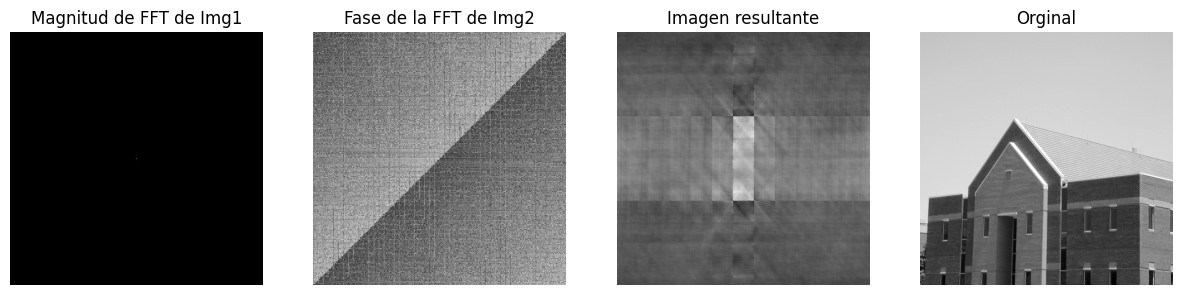

In [34]:
# Mostrando imágenes normalizadas
show_imgs_row(
    [normalize_img(mag_fft_img1), normalize_img(fase_fft_img2), normalize_img(inv_fft_mag_img1_fase_img2), img1],
    titles = [
        "Magnitud de FFT de Img1",
        "Fase de la FFT de Img2",
        "Imagen resultante",
        "Orginal"
    ],
    is_double = [True, True, True, True],
    size = (15,15),
)

## 6. (1 puntos) Genere una nueva transformada de Fourier que se llame FFTMagUnosFaseIm1 formada con la magnitud MagUnos y la fase FaseFFTIm1. A la transformada resultante apliquele la transformada inversa (ifft2) y despliegue la imagen obtenida. ¿Qué se ve?

In [28]:
# Combina la magnitud de MagUnos y la fase de fase_fft_img1 para crear una nueva Transformada de Fourier
fft_mag_unos_fase_img1 = mag_unos * np.exp(1j * ifftshift(fase_fft_img1))

# Aplica la Transformada de Fourier Inversa (IFFT) a la nueva Transformada de Fourier
inv_fft_mag_unos_fase_img1 = np.real(ifft2(fft_mag_unos_fase_img1))

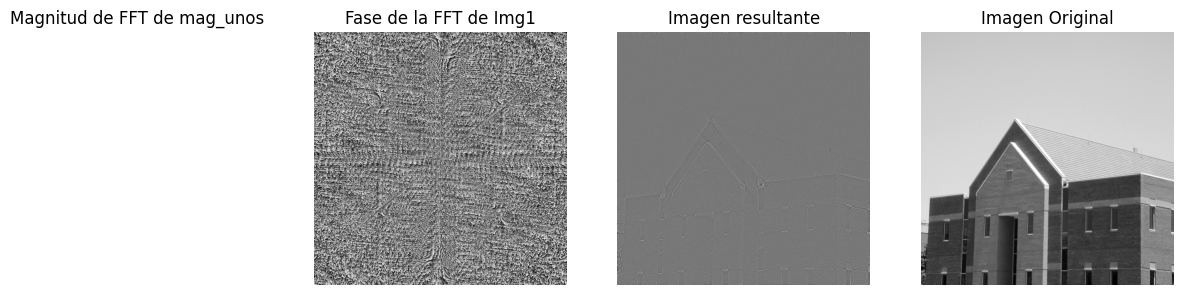

In [40]:
# Mostrando imágenes normalizadas
show_imgs_row(
    [normalize_img(mag_unos), normalize_img(fase_fft_img1), normalize_img(inv_fft_mag_unos_fase_img1), img1],
    titles = [
        "Magnitud de FFT de mag_unos",
        "Fase de la FFT de Img1",
        "Imagen resultante",
        "Imagen Original"
    ],
    is_double = [True, True, True, True],
    size = (15,15),
)

La imagen resultante mostrará una combinación de características de ambas imágenes, es decir, la magnitud de la imagen MagUnos y la fase de la Transformada de Fourier de img1. La imagen resultante es una versión modificada de la imagen original img1. Es posible que las características de la imagen original sean reconocibles, pero con ciertas distorsiones, ya que la magnitud se ha reemplazado por unos. Esto puede dar lugar a patrones visuales diferentes en comparación con la imagen original.

## 7. (1 puntos) Genere una nueva transformada de Fourier que se llame FFTMagUnosFaseIm12 formada con la magnitud MagUnos y la fase FaseFFTIm2. A la transformada resultante apliquele la transformada inversa (ifft2) y despliegue la imagen obtenida. ¿Qué se ve?

In [37]:
# Combina la magnitud de MagUnos y la fase de fase_fft_img1 para crear una nueva Transformada de Fourier
fft_mag_unos_fase_img2 = mag_unos * np.exp(1j * ifftshift(fase_fft_img2))

# Aplica la Transformada de Fourier Inversa (IFFT) a la nueva Transformada de Fourier
inv_fft_mag_unos_fase_img2 = np.real(ifft2(fft_mag_unos_fase_img2))

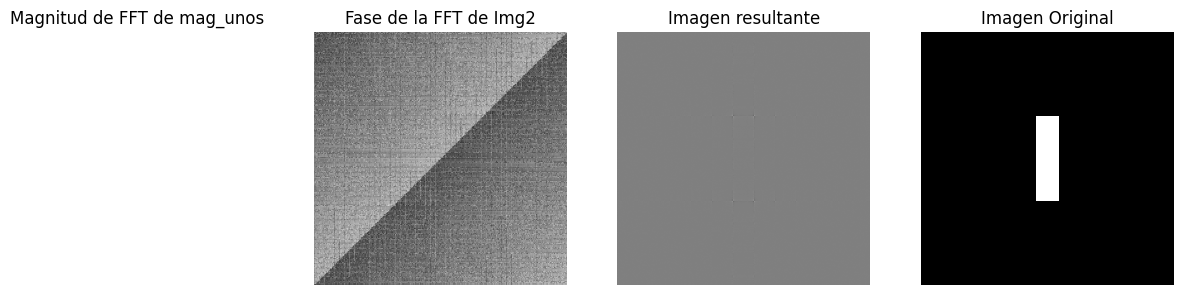

In [39]:
# Mostrando imágenes normalizadas
show_imgs_row(
    [normalize_img(mag_unos), normalize_img(fase_fft_img2), normalize_img(inv_fft_mag_unos_fase_img2), img2],
    titles = [
        "Magnitud de FFT de mag_unos",
        "Fase de la FFT de Img2",
        "Imagen resultante",
        "Imagen Original"
    ],
    is_double = [True, True, True, True],
    size = (15,15),
)

## 8. (1 puntos) Genere una nueva transformada de Fourier que se llame FFTMagIm2FasePiMedios formada con la magnitud MagFFTIm2 y la fase FasePiMedios. A la transformada resultante apliquele la transformada inversa (ifft2) y despliegue la imagen obtenida. ¿Qué se ve?

In [45]:
# Combina la magnitud de img2 y la fase de de pi_medios para crear una nueva Transformada de Fourier
fft_mag_img2_fase_pi_medios = mag_fft_img2 * np.exp(1j * ifftshift(fase_pi_medios))

# Aplica la Transformada de Fourier Inversa (IFFT) a la nueva Transformada de Fourier
inv_fft_mag_img2_fase_pi_medios = np.real(ifft2(fft_mag_img2_fase_pi_medios))

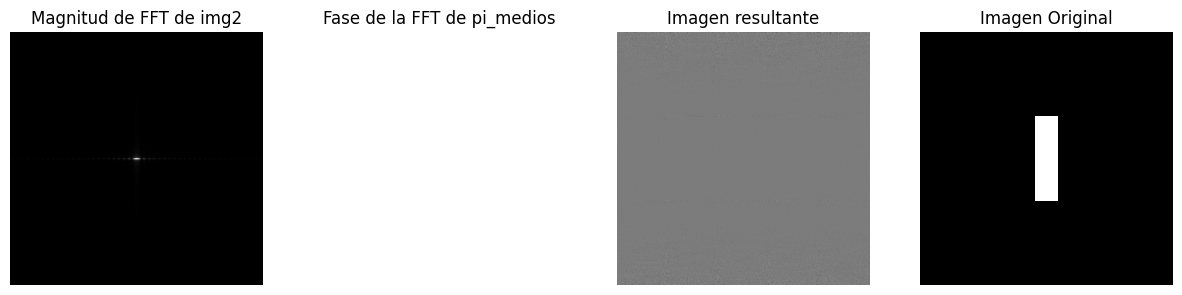

In [44]:
# Mostrando imágenes normalizadas
show_imgs_row(
    [normalize_img(mag_fft_img2), normalize_img(fase_pi_medios), normalize_img(inv_fft_mag_img2_fase_pi_medios), img2],
    titles = [
        "Magnitud de FFT de img2",
        "Fase de la FFT de pi_medios",
        "Imagen resultante",
        "Imagen Original"
    ],
    is_double = [True, True, True, True],
    size = (15,15),
)

## 9. (1 puntos) Genere una nueva transformada de Fourier que se llame FFTMagIm1FasePiMedios formada con la magnitud MagFFTIm1 y la fase FasePiMedios. A la transformada resultante apliquele la transformada inversa (ifft2) y despliegue la imagen obtenida. ¿Qué se ve?

In [46]:
# Combina la magnitud de img1 y la fase de pi_medios para crear una nueva Transformada de Fourier
fft_mag_img1_fase_pi_medios = mag_fft_img1 * np.exp(1j * ifftshift(fase_pi_medios))

# Aplica la Transformada de Fourier Inversa (IFFT) a la nueva Transformada de Fourier
inv_fft_mag_img1_fase_pi_medios = np.real(ifft2(fft_mag_img1_fase_pi_medios))

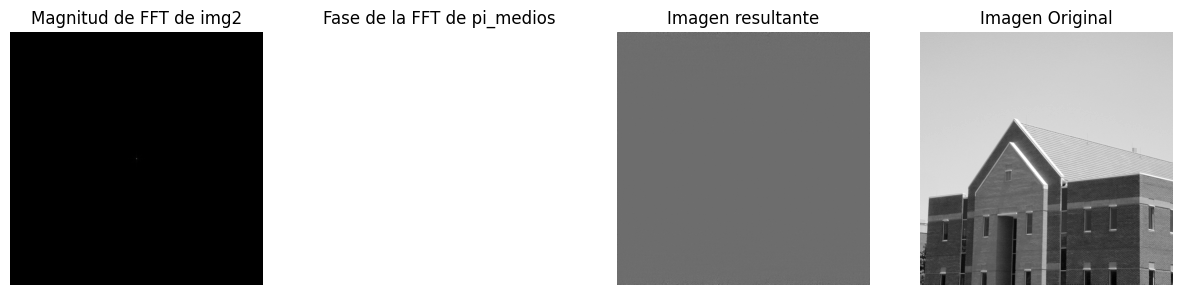

In [47]:
# Mostrando imágenes normalizadas
show_imgs_row(
    [normalize_img(mag_fft_img1), normalize_img(fase_pi_medios), normalize_img(inv_fft_mag_img1_fase_pi_medios), img1],
    titles = [
        "Magnitud de FFT de img2",
        "Fase de la FFT de pi_medios",
        "Imagen resultante",
        "Imagen Original"
    ],
    is_double = [True, True, True, True],
    size = (15,15),
)